# Example: Downloading datasets with the `ecmwfapi`

**Note:** Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

**Note:** The WASM-based version of the compression lab running inside JupyterLite has only been tested in recent Firefox browsers.

## Installing and configuring the `ecmwfapi` package

To run this example, you need an API key available from https://api.ecmwf.int/v1/key/, which looks as follows:

```json
{
    "url"   : "<ECMWF-API-URL>",
    "key"   : "<ECMWF-API-KEY>",
    "email" : "<ECMWF-API-EMAIL>"
}
```

Please enter these values to configure the `ECMWFDataServer` in the next cell.

Please remember that you must keep your API key private and should not share a notebook that contains your API key.

In [1]:
from ecmwfapi import ECMWFDataServer

server = ECMWFDataServer(**{
    "url"   : "<ECMWF-API-URL>",
    "key"   : "<ECMWF-API-KEY>",
    "email" : "<ECMWF-API-EMAIL>"
})

[pyodide]: Loading ecmwf-api-client
[pyodide]: Loaded ecmwf-api-client


## Retrieving the dataset

You can now retrieve the following example GRIB dataset. Once the download has completed, you should have a new `data.grib` file in your local directory.

In [2]:
server.retrieve(
    {
        "dataset": "tigge",
        "date": "2024-08-02",
        "expver": "prod",
        "grid": "1/1",
        "levtype": "pl",
        "levelist": "1000",
        "model": "glob",
        "origin": "ecmwf",
        "param": "130",
        "step": "240",
        "time": "00:00:00",
        "type": "fc",
        "target": "t.grib",
    }
)

2024-09-26 19:24:50 ECMWF API python library 1.6.3
2024-09-26 19:24:50 ECMWF API at https://api.ecmwf.int/v1
2024-09-26 19:24:50 Welcome Juniper Tyree
2024-09-26 19:24:52 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2024-09-26 19:24:52 ------------ WARNING ------------
2024-09-26 19:24:52 Access to this dataset is transitioning to a new interface, dates to be announced soon
2024-09-26 19:24:52 For more information on how to access this data in the future, visit https://confluence.ecmwf.int/x/-wUiEw
2024-09-26 19:24:52 ---------------------------------
2024-09-26 19:24:52 Request submitted
2024-09-26 19:24:52 Request id: 66f58ad48b4ba1c089ecec15
2024-09-26 19:24:52 Request is submitted
2024-09-26 19:24:54 Request is active
2024-09-26 19:24:59 Calling 'nice mars /tmp/20240926-1620/b5/tmp-_mars-kzNIZc.req'
2024-09-26 19:24:59 Forcing MIR_CACHE_PATH=/data/ec_coeff
2024-09-26 19:24:59 mars - WARN -
2024-09-26 19:2

In [3]:
import earthkit
import xarray as xr

ds = xr.open_dataset("t.grib")
ds

[pyodide]: Loading xarray, pandas, tzdata, earthkit, earthkit-data, cfgrib, attrs, click, eccodes, cffi, pycparser, findlibs, dask, cloudpickle, importlib_metadata, zipp, Jinja2, MarkupSafe, partd, locket, toolz, pyyaml, entrypoints, filelock, jsonschema, pyrsistent, markdown, multiurl, tqdm, netcdf4, cftime, h5py, pkgconfig, pdbufr, earthkit-meteo, earthkit-geo, pyproj, scipy, openblas, earthkit-maps, Cartopy, shapely, pyshp, geos, adjustText, earthkit-plots, earthkit-plots-default-styles, pint, typing-extensions, earthkit-regrid, earthkit-transforms, geopandas, fiona, setuptools, distutils, cligj, rasterio, affine, gdal, click-plugins
[pyodide]: Loaded Cartopy, Jinja2, MarkupSafe, adjustText, affine, attrs, cffi, cfgrib, cftime, click, click-plugins, cligj, cloudpickle, dask, distutils, earthkit, earthkit-data, earthkit-geo, earthkit-maps, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-transforms, eccodes, entrypoints, filelock, findlibs, fio

/lib/python3.11/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


<xarray.Dataset>
Dimensions:        (latitude: 181, longitude: 360)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
    isobaricInhPa  float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     datetime64[ns] ...
Data variables:
    t              (latitude, longitude) float64 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-26T19:25 GRIB to CDM+CF via cfgrib-0.9.1...

## Plotting the dataset

We finally plot the loaded dataset. `earthkit` provides the

```python
earthkit.maps.quickplot(
    *data, blueprint=..., units=None, style=None, disjoint=False, show=True, **kwargs
) -> matplotlib.figure.Figure
```

helper function to plot weather and climate maps data.

In this example, we plot the temperature variable `t` from the dataset.

In [4]:
da = ds["t"]

/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


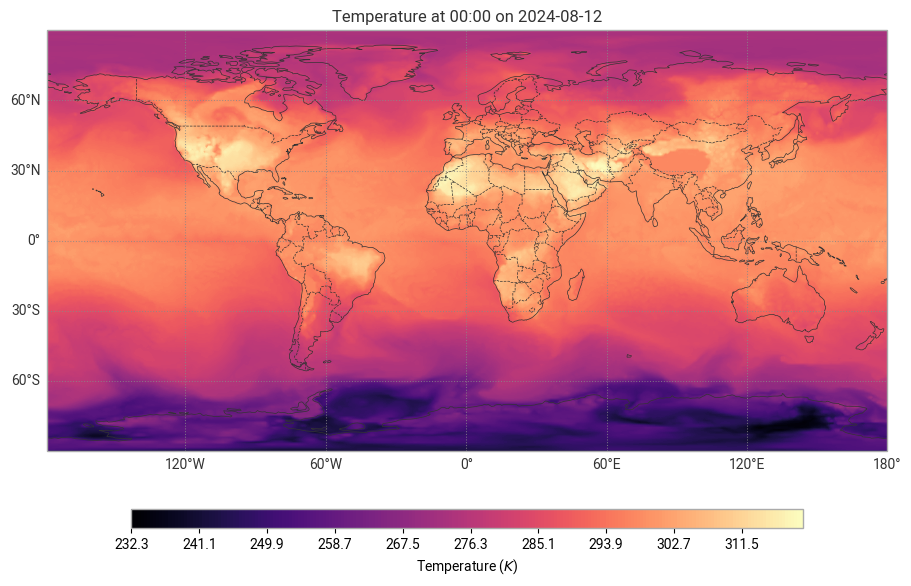

In [5]:
earthkit.maps.quickplot(
    da,
    style=earthkit.maps.Style(
        levels=earthkit.maps.styles.levels.auto_range(da, n_levels=256),
    ),
);